In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import learning_curve
import seaborn as sns
from sklearn import tree
from sklearn.preprocessing import StandardScaler

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%run functions.ipynb
%run ./Normalizing.ipynb

import graphviz
import os


os.environ['PATH'] = os.environ['PATH'] + ';C:/Program Files (x86)/Graphviz2.38/bin'

target_variable = ['Attrition']

classifier_variables = ['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'NonTravel', 'TravelRarely', 'TravelFrequently', 'D_R&D', 'D_Sales',
       'D_RH', 'E_LifeSciences', 'E_Medical', 'E_Marketing',
       'E_TechnicalDegree', 'E_RH', 'E_Other', 'Male', 'Female', 'Single',
       'Married', 'Divorced']


In [10]:
data = df_norm.apply(pd.to_numeric)

## Test and Training

In [11]:
X = data[classifier_variables].values
Y = data[target_variable].values
classes=['Negative Attrition (not leaving)','Positive attrition (leaving)']
#Y[idx] = 1
#Y[~idx]= 0

# Dividir 20% dos dados para o conjunto out-of-sample de teste
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X,
                                                                Y,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=Y)

# Objeto de validacao cruzada
cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0)

## Curva de aprendizado

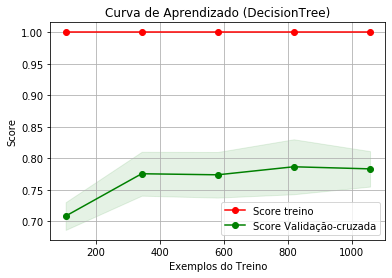

In [12]:
plt.figure()

scorer = metrics.make_scorer(metrics.accuracy_score)

title = "Curva de Aprendizado (DecisionTree)"
estimator = tree.DecisionTreeClassifier(random_state=0)
plot_learning_curve(estimator, title, Xtrain, Ytrain, ax=plt.gca(),
                    cv=cvfold.split(Xtrain, Ytrain, groups=Ytrain),
                    scoring=scorer, n_jobs=3);

## Training Pipeline

In [13]:
model_dict = {
    'RandomForest': ensemble.RandomForestClassifier(n_estimators=10, max_features='sqrt'),
    'LogisticRegr': LogisticRegression(),
    'kNN': KNeighborsClassifier(weights='distance'),
    'SVM': SVC(probability=False, gamma='auto'),
}

model_conf = {
    'RandomForest': {
        'Model__max_depth': [4, 6],
        'Model__n_estimators': [10, 50],

    },
    'LogisticRegr': {
        'Model__C': [0.001, 0.1, 1, 10],
    },
    'kNN': {
        'Model__n_neighbors': [5, 10, 20],
    },
    'SVM': {
        'Model__kernel': ['rbf',],
        'Model__C' : [0.1, 1, 10],
    }
}

scorer = metrics.make_scorer(metrics.f1_score)

model_list = {}

for model_name in model_dict.keys():
    conf_train_pipe = [
        
        ('Model', model_dict[model_name]),
    ]
    
    # Create Pipeline
    model_pipe = pipeline.Pipeline(conf_train_pipe)
    param_grid = model_conf[model_name].copy()
    model_pipe = model_selection.GridSearchCV(model_pipe, param_grid,
                                              scoring=scorer,
                                              cv=cvfold,
                                              return_train_score=True,)

    model_pipe.fit(Xtrain, Ytrain)
    model_list[model_name] = model_pipe 


## ROC CURVE

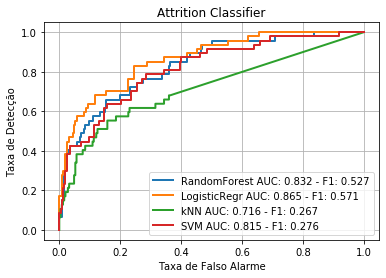

In [14]:
plt.figure(figsize=(6,4))

for model_name in model_dict.keys():
    model = model_list[model_name]
    # estimate Y
    if model_name in ['RandomForest', 'SVM']:
        final_model = LogisticRegressionCV(Cs=20,cv=5)
        if model_name == 'SVM':
            Yhat_train = model.decision_function(Xtrain)
            Yhat = model.decision_function(Xtest)
        else:
            Yhat_train = model.predict_proba(Xtrain)[:,1]
            Yhat = model.predict_proba(Xtest)[:,1]
            
        final_model.fit(Yhat_train.reshape(-1, 1), Ytrain)
        Yhat  = final_model.predict_proba(Yhat.reshape(-1,1))[:,1]
        Ypred = final_model.predict(Yhat.reshape(-1,1))
    else:
        Yhat = model.predict_proba(Xtest)[:,1]
        Ypred = model.predict(Xtest)
    
    
    fpr, tpr, thr = metrics.roc_curve(Ytest, Yhat)
    auc = metrics.roc_auc_score(Ytest, Yhat)
    f1 = metrics.f1_score(Ytest, Ypred)
    label = model_name + " AUC: %.3f - F1: %.3f"%(auc, f1)
    plt.plot(fpr, tpr, '-', lw=2, label=label)
    
plt.legend()
plt.title('Attrition Classifier')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção');

## Choosing 'LogisticRegr' as model

In [15]:
model_name = 'LogisticRegr'

## Confusion Matrix

In [16]:


model = model_list[model_name]
Ypred = model.predict(Xtest)

col_names = ['Model ' + s for s in ['Neg','Pos']]
idx_names = ['Real ' + s for s in ['Neg','Pos']]

cmat = metrics.confusion_matrix(Ytest, Ypred)
cmat = pd.DataFrame(cmat, index=idx_names,
                              columns=col_names)
cmat['Real Total'] = cmat.sum(axis=1)
cmat.loc['Model Total',:] = cmat.sum(axis=0)
cmat = cmat.astype(int)
cmat


,Model Neg,Model Pos,Real Total
Real Neg,239,8,247
Real Pos,25,22,47
Model Total,264,30,294


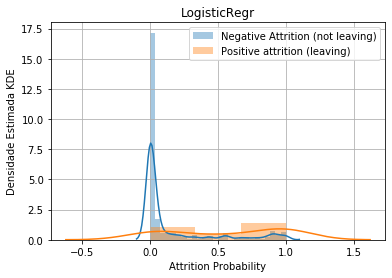

In [17]:
for i in range(len(classes)):
    # 2 Classes case
    sns.distplot(Yhat[(np.squeeze(np.array(Ytest==i)))], label=classes[i])

plt.title(model_name)
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Attrition Probability')
plt.grid()
plt.legend();

## Metrics evaluation

In [18]:
print(metrics.classification_report(Ytest, Ypred,target_names=classes))

                                  precision    recall  f1-score   support

Negative Attrition (not leaving)       0.91      0.97      0.94       247
    Positive attrition (leaving)       0.73      0.47      0.57        47

                        accuracy                           0.89       294
                       macro avg       0.82      0.72      0.75       294
                    weighted avg       0.88      0.89      0.88       294



## Saving results on excel (not working)

In [19]:
model_name = 'LogisticRegr'

test_data = [Xtest, Ytest,]
df_cols = ['text', 'class'] 
for model_name in model_dict.keys():
    model = model_list[model_name]
    if model_name in ['RandomForest', 'SVM']:
        final_model = LogisticRegressionCV(Cs=20,cv=5)
        if model_name == 'SVM':
            Yhat_train = model.decision_function(Xtrain)
            Yhat = model.decision_function(Xtest)
        else:
            Yhat_train = model.predict_proba(Xtrain)[:,1]
            Yhat = model.predict_proba(Xtest)[:,1]
            
        final_model.fit(Yhat_train.reshape(-1, 1), Ytrain)
        Yhat  = final_model.predict_proba(Yhat.reshape(-1,1))[:,1]
    else:
        Yhat = model.predict_proba(Xtest)[:,1]

    test_data.append(Yhat)
    df_cols.append(model_name)
        
test_data = np.array(test_data).T
df_test = pd.DataFrame(data=test_data, columns=df_cols)

test_data = np.array(test_data).T
df_test = pandas.DataFrame(data=test_data, columns=df_cols)

df_test

ResultsPath = '../../Docs/Model/Results.xlsx'
df_test.to_excel(ResultsPath,index = True)

ValueError: could not broadcast input array from shape (294,40) into shape (294)

In [ ]:
print(Yhat.shape)
print(Xtrain.shape)
print(Xtest.shape)